## AB browser test

В данном задании вам нужно будет
- проанализировать АБ тест, проведенный на реальных пользователях Яндекса
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
- определить характер этих изменений и практическую значимость вводимого изменения
- понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

### Описание данных:
- userID: уникальный идентификатор пользователя
- browser: браузер, который использовал userID
- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
- n_clicks: количество кликов, которые пользоваль совершил за n_queries
- n_queries: количество запросов, который совершил userID, пользуясь браузером browser
- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ab_data = pd.read_csv('ab_browser_test.csv')
ab_data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
userID              566134 non-null int64
browser             566134 non-null object
slot                566134 non-null object
n_clicks            566134 non-null int64
n_queries           566134 non-null int64
n_nonclk_queries    566134 non-null int64
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [4]:
ab_data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


### Вопрос 1

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [5]:
ab_data['slot'].value_counts()

control    284554
exp        281580
Name: slot, dtype: int64

In [6]:
exp_num = ab_data[ab_data['slot'] == 'exp']['n_clicks'].sum()
ctrl_sum = ab_data[ab_data['slot'] == 'control']['n_clicks'].sum()

print('Total number of clicks in each group:')
print('Exp: %d' % exp_num)
print('Control: %d' % ctrl_sum)

Total number of clicks in each group:
Exp: 3261823
Control: 3210027


In [7]:
# Proportion increase of clicks for exp over control
prop_inc_clicks = (exp_num / ctrl_sum - 1) * 100
print('Proportion increase of clicks for exp over control: %.3f%%' % prop_inc_clicks)

Proportion increase of clicks for exp over control: 1.614%


### Вопрос 2

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого построим с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

In [8]:
# Clicks mean values
exp_cl_mean = ab_data[ab_data['slot'] == 'exp']['n_clicks'].mean()
ctrl_cl_mean = ab_data[ab_data['slot'] == 'control']['n_clicks'].mean()
print('Mean number of clicks in each group')
print('Exp: %.4f' % exp_cl_mean)
print('Control: %.4f' % ctrl_cl_mean)
print('')

# Clicks median values
exp_cl_median = ab_data[ab_data['slot'] == 'exp']['n_clicks'].median()
ctrl_cl_median = ab_data[ab_data['slot'] == 'control']['n_clicks'].median()
print('Median number of clicks in each group')
print('Exp: %d' % exp_cl_median)
print('Control: %d' % ctrl_cl_median)

Mean number of clicks in each group
Exp: 11.5840
Control: 11.2809

Median number of clicks in each group
Exp: 5
Control: 4


In [9]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [10]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

### Интервальная оценка для средних значений и медиан

In [11]:
exp_cl = ab_data[ab_data['slot'] == 'exp']['n_clicks'].values
ctrl_cl = ab_data[ab_data['slot'] == 'control']['n_clicks'].values

In [12]:
%%time
#confidence intervals estimation
np.random.seed(0)

exp_median_scores = list(map(np.median, get_bootstrap_samples(exp_cl, 500)))
ctrl_median_scores = list(map(np.median, get_bootstrap_samples(ctrl_cl, 500)))

exp_mean_scores = list(map(np.mean, get_bootstrap_samples(exp_cl, 500)))
ctrl_mean_scores = list(map(np.mean, get_bootstrap_samples(ctrl_cl, 500)))

Wall time: 23.6 s


In [13]:
print("95% confidence interval for the Exp median repair time:",  stat_intervals(exp_median_scores, 0.05))
print("95% confidence interval for the Control median repair time:",  stat_intervals(ctrl_median_scores, 0.05))

print("95% confidence interval for the Exp mean repair time:",  stat_intervals(exp_mean_scores, 0.05))
print("95% confidence interval for the Control mean repair time:",  stat_intervals(ctrl_mean_scores, 0.05))

95% confidence interval for the Exp median repair time: [5. 5.]
95% confidence interval for the Control median repair time: [4. 4.]
95% confidence interval for the Exp mean repair time: [11.50748109 11.65752157]
95% confidence interval for the Control mean repair time: [11.21392679 11.3570817 ]


### Точечная оценка разности средних значений и медиан

In [14]:
print("difference between medians:", np.median(exp_cl) - np.median(ctrl_cl))
print("difference between means: %.4f" % (np.mean(exp_cl) - np.mean(ctrl_cl)))

difference between medians: 1.0
difference between means: 0.3031


### Интервальная оценка разности для средних значений и медиан

In [15]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(exp_median_scores, ctrl_median_scores))
delta_median_scores = list(delta_median_scores)

In [16]:
print("95% confidence interval for the difference between medians", stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-1. -1.]


In [17]:
delta_mean_scores = map(lambda x: x[1] - x[0], zip(exp_mean_scores, ctrl_mean_scores))
delta_mean_scores = list(delta_mean_scores)

In [18]:
print('95% confidence interval for the difference between means: [{0:.4f}, {1:.4f}]'.format(stat_intervals(delta_mean_scores, 0.05)[0], stat_intervals(delta_mean_scores, 0.05)[1]))

95% confidence interval for the difference between means: [-0.4003, -0.1886]


### Вопрос 3

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

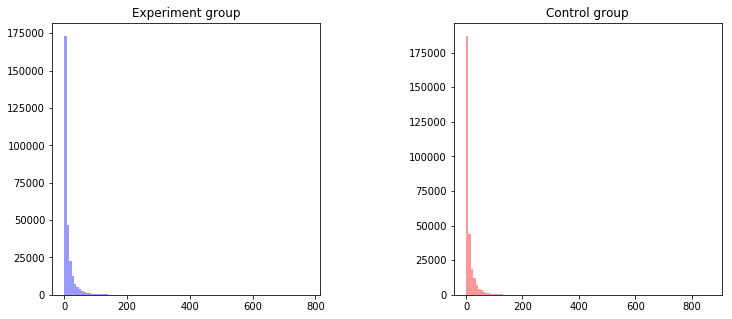

In [8]:
f, axes = plt.subplots(1, 2)

fig = plt.gcf()
fig.set_size_inches(12,5)

sns.distplot(ab_data[ab_data['slot'] == 'exp']['n_clicks'].values, bins=100, kde=False, color="blue", ax=axes[0]);

sns.distplot(ab_data[ab_data['slot'] == 'control']['n_clicks'].values, bins=100, kde=False, color="red", ax=axes[1]);

axes[0].set_title('Experiment group')
axes[1].set_title('Control group')

plt.subplots_adjust(wspace=0.5)
plt.show()

### Вопрос 4

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

- $\bar{X}$ — среднее значение в выборке — было распределено нормально $N(μ,\frac{σ^2}n)$ 
- $\frac{n}σ^2{S^2}$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c $n−1$ степенями свободы $χ2(n−1)$

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

- Получите из данных n_boot_samples псевдовыборок.
- По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
- Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
- Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды

In [19]:
num_of_samples = 500

ctrl_var_boot = np.empty(num_of_samples)
ctrl_mean_boot = np.empty(num_of_samples)

ctrl_data = get_bootstrap_samples(ctrl_cl, num_of_samples)

for i in range(num_of_samples):
    ctrl_var_boot[i] = ctrl_data[i].var()
    ctrl_mean_boot[i] = ctrl_data[i].mean()

In [31]:
# ctrl_mean_boot = list(map(np.mean, get_bootstrap_samples(ctrl_cl, 500)))
# ctrl_var_boot = list(map(np.var, get_bootstrap_samples(ctrl_cl, 500)))

In [49]:
# ctrl_mean_boot
# ctrl_var_boot

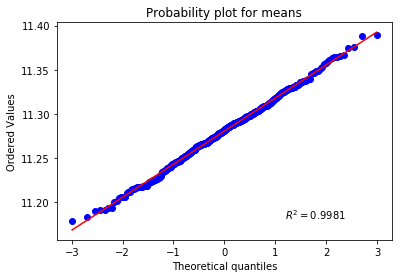

In [20]:
# Probability plot for means
stats.probplot(ctrl_mean_boot, plot=plt, rvalue=True)
plt.title('Probability plot for means');

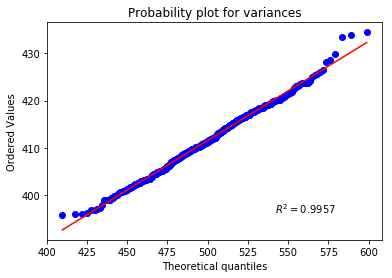

In [21]:
# Probability plot for variances
stats.probplot(ctrl_var_boot, plot=plt, dist='chi2', sparams=(len(ctrl_var_boot)-1), rvalue=True)
plt.title('Probability plot for variances');

### Вопрос 5

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ?

In [36]:
users_nclicks_exp = ab_data[ab_data['slot'] == 'exp'].groupby(['userID']).sum()['n_clicks']
users_nclicks_ctrl = ab_data[ab_data['slot'] == 'control'].groupby(['userID']).sum()['n_clicks']

In [37]:
users_nclicks_exp = users_nclicks_exp.to_frame()
users_nclicks_ctrl = users_nclicks_ctrl.to_frame()

In [38]:
users_nclicks_exp.reset_index(level=0, inplace=True)
users_nclicks_ctrl.reset_index(level=0, inplace=True)

In [157]:
users_nclicks_exp.head()

,userID,n_clicks
0,1,23
1,3,3
2,5,29
3,7,54
4,9,6


In [158]:
users_nclicks_ctrl.head()

,userID,n_clicks
0,6,12
1,8,4
2,10,22
3,15,2
4,23,3


In [42]:
# ids = ab_data['userID']
# ab_data[ids.isin(ids[ids.duplicated()])].head()

# users_nclicks_exp[users_nclicks_exp['userID'] == 1783]

In [46]:
stats.mannwhitneyu(users_nclicks_exp['n_clicks'], users_nclicks_ctrl['n_clicks'], alternative='two-sided')

MannwhitneyuResult(statistic=41140868471.0, pvalue=8.694294377520879e-75)

### Вопрос 6

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с \alpha=0.05α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

In [84]:
# Unique browsers
browsers = np.unique(ab_data['browser'])
print('Unique browsers: ' + str(browsers))
print('')

Unique browsers: ['Browser #14' 'Browser #17' 'Browser #2' 'Browser #20' 'Browser #22'
 'Browser #4']



In [99]:
# browsers_14_nclicks_exp = ab_data[(ab_data['slot'] == 'exp') & (ab_data['browser'] == 'Browser #14')]['n_clicks']
# browsers_14_nclicks_exp.head()

In [100]:
browsers_nclicks_exp = ab_data[ab_data['slot'] == 'exp'].groupby(['browser', 'userID']).sum()['n_clicks']
browsers_nclicks_ctrl = ab_data[ab_data['slot'] == 'control'].groupby(['browser', 'userID']).sum()['n_clicks']

In [101]:
browsers_nclicks_exp = browsers_nclicks_exp.to_frame()
browsers_nclicks_ctrl = browsers_nclicks_ctrl.to_frame()

In [130]:
browsers_nclicks_exp.reset_index(level=0, inplace=True)
browsers_nclicks_ctrl.reset_index(level=0, inplace=True)

In [131]:
browsers_nclicks_exp.head()

,userID,browser,n_clicks
0,13,Browser #14,2
1,30,Browser #14,4
2,33,Browser #14,22
3,45,Browser #14,5
4,83,Browser #14,0


In [132]:
browsers_nclicks_ctrl.head()

,userID,browser,n_clicks
0,15,Browser #14,2
1,39,Browser #14,0
2,56,Browser #14,4
3,81,Browser #14,2
4,88,Browser #14,2


In [156]:
print('Mann-Whitney rank test without multipletest')
mw_p = np.empty(browsers.shape[0])
for i, br in enumerate(browsers):
    _, mw_p[i] = stats.mannwhitneyu(browsers_nclicks_exp[browsers_nclicks_exp['browser'] == br]['n_clicks'], 
                                    browsers_nclicks_ctrl[browsers_nclicks_ctrl['browser'] == br]['n_clicks'], 
                                    alternative='two-sided')
    print('{0}: p-value = {1:.4f}'.format(br, mw_p[i])) 

print()
print('Mann-Whitney rank test with multipletest')
_, mw_p_corr, _, _ = multipletests(mw_p, alpha = 0.05, method = 'holm')
for i, br in enumerate(browsers):
    print('{0}: p-value = {1:.4f}'.format(br, mw_p_corr[i]))

Mann-Whitney rank test without multipletest
Browser #14: p-value = 0.0000
Browser #17: p-value = 0.0748
Browser #2: p-value = 0.0545
Browser #20: p-value = 0.9073
Browser #22: p-value = 0.5148
Browser #4: p-value = 0.8152

Mann-Whitney rank test with multipletest
Browser #14: p-value = 0.0000
Browser #17: p-value = 0.2992
Browser #2: p-value = 0.2724
Browser #20: p-value = 1.0000
Browser #22: p-value = 1.0000
Browser #4: p-value = 1.0000


### Вопрос 7

Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

In [182]:
browsers_nonclk_q_exp = ab_data[ab_data['slot'] == 'exp'].groupby(['browser']).sum()['n_nonclk_queries']
browsers_clk_q_exp = ab_data[ab_data['slot'] == 'exp'].groupby(['browser']).sum()['n_queries']
browsers_nonclk_q_prop_exp = browsers_nonclk_q_exp / browsers_clk_q_exp

browsers_nonclk_q_ctrl = ab_data[ab_data['slot'] == 'control'].groupby(['browser']).sum()['n_nonclk_queries']
browsers_clk_q_ctrl = ab_data[ab_data['slot'] == 'control'].groupby(['browser']).sum()['n_queries']
browsers_nonclk_q_prop_ctrl = browsers_nonclk_q_ctrl / browsers_clk_q_ctrl

print('Control / experimental groups')
for br in browsers:
    print('{0} '.format(br), end='')
    print(browsers_nonclk_q_prop_ctrl[browsers_nonclk_q_prop_ctrl.index == br].values, end=' '),
    print('/ ', end=''),
    print(browsers_nonclk_q_prop_exp[browsers_nonclk_q_prop_ctrl.index == br].values)

Control / experimental groups
Browser #14 [0.57590411] / [0.43755617]
Browser #17 [0.36299367] / [0.36937413]
Browser #2 [0.45962747] / [0.44982747]
Browser #20 [0.40540485] / [0.38977376]
Browser #22 [0.40593977] / [0.39853947]
Browser #4 [0.4697093] / [0.45142942]
